Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
    last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
        return dest_filename
    else:
        raise Exception(
        'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
def show_letter(letter='a', data='train', how='image'):
    """
    Show image of a letter
    letter: A-J
    data: train, test
    how: image (Image), imshow (plt.imshow)
    """
    print("Letter: {}".format(letter))
    if data == 'train':
        folder = 'notMNIST_large'
    elif data == 'test':
        folder = 'notMNIST_small'
    path = os.path.join(folder, letter.upper())
    random_img = np.random.choice(os.listdir(path))
    if how == 'image':
        return Image(os.path.join(path, random_img))
    else:
        img = imageio.imread(os.path.join(path, random_img))
        plt.figure(figsize=(2, 2))
        plt.axis('off')
        
        plt.imshow(img, cmap='gray')

In [5]:
show_letter(letter='F', data='test')

Letter: F


Letter: C


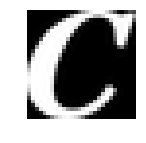

In [6]:
show_letter(letter='C', data='test', how='imshow')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [8]:
def show_proc_letter(data='test'):
    """
    Show the processed image of a letter
    size: large, small
    """
    if data == 'test':
        path = np.random.choice(test_datasets)
    elif data == 'train':
        path = np.random.choice(train_datasets)
    with open(path, 'rb') as f:
        data = pickle.load(f)
    
    
    random_index = np.random.choice(range(data.shape[0]))
    print("Letter: {}".format(path.split('.')[-2][-1]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(data[random_index], cmap='gray')

Letter: I


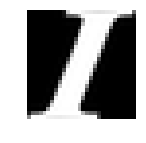

In [9]:
show_proc_letter()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [10]:
def verify_balance(data='test'):
    if data.lower() == 'test':
        path_images = test_folders
        print("Test data:")
    elif data.lower() == 'train':
        path_images = train_folders
        print("Train data:")
    for path in path_images:
        print("Letter: {}, size: {}".format(path[-1], len(os.listdir(path))))
        
verify_balance(data='train')
verify_balance(data='test')

Train data:
Letter: A, size: 52912
Letter: B, size: 52912
Letter: C, size: 52912
Letter: D, size: 52912
Letter: E, size: 52912
Letter: F, size: 52912
Letter: G, size: 52912
Letter: H, size: 52912
Letter: I, size: 52912
Letter: J, size: 52911
Test data:
Letter: A, size: 1873
Letter: B, size: 1873
Letter: C, size: 1873
Letter: D, size: 1873
Letter: E, size: 1873
Letter: F, size: 1873
Letter: G, size: 1872
Letter: H, size: 1872
Letter: I, size: 1872
Letter: J, size: 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [11]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [12]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

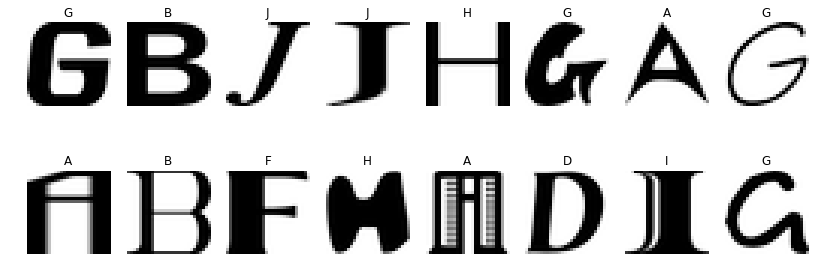

In [13]:
STR = "ABCDEFGHIJ"
pretty_labels = dict([[i, ch] for i, ch in enumerate(STR)])

def disp_sample_dataset(dataset, labels):
    items = np.random.choice(range(len(labels)), 16)
    plt.figure(figsize=(14, 5))
    for i, item in enumerate(items):
        plt.subplot(2, 8, i+1)
        plt.axis('off')
        plt.title(pretty_labels[labels[item]])
        plt.imshow(dataset[item], cmap='Greys')

disp_sample_dataset(train_dataset, train_labels)

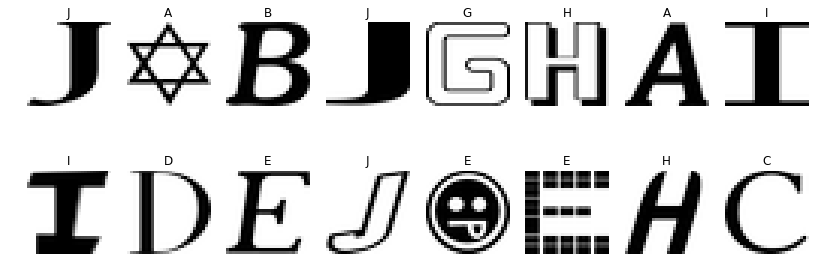

In [16]:
disp_sample_dataset(valid_dataset, valid_labels)

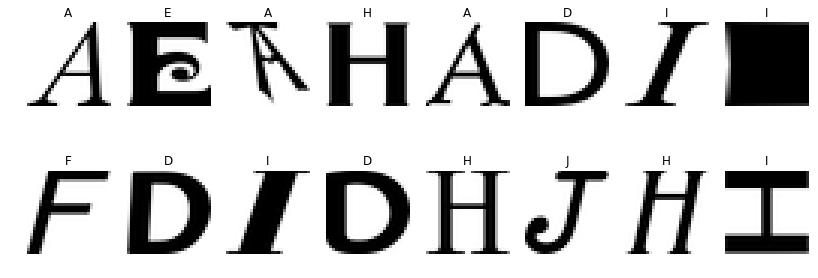

In [17]:
disp_sample_dataset(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [18]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [3]:
from PIL import Image
import imagehash
import pandas as pd

In [4]:
data = pickle.load(open('notMNIST.pickle', 'rb'))

In [5]:
train_dataset = data['train_dataset']
train_labels = data['train_labels']

valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

test_dataset = data['test_dataset']
test_labels = data['test_labels']

I want to use imagehashes to know where are duplicates. So, first of all I need to renormalize images.

In [7]:
train_dataset_proc = train_dataset * 255.0 + 112.5
valid_dataset_proc = valid_dataset * 255.0 + 112.5
test_dataset_proc = test_dataset * 255.0 + 112.5

Calculate perception hash and add string column of this hash

In [9]:
def calculate_hashes(data):
    hashes = []
    for img in data:
        img = Image.fromarray(img)
        hashes.append(imagehash.phash(img))
    return hashes

def get_hash_df(data):
    hash_df = pd.DataFrame(calculate_hashes(data), columns=['img_hash'])
    hash_df['img_hash_str'] = hash_df['img_hash'].apply(lambda h: str(h))
    return hash_df

In [13]:
%%time
train_hash_df = get_hash_df(train_dataset_proc)
valid_hash_df = get_hash_df(valid_dataset_proc)
test_hash_df = get_hash_df(test_dataset_proc)

CPU times: user 3min 38s, sys: 368 ms, total: 3min 38s
Wall time: 3min 39s


It seems there are a lot of duplicates in the data.

In [14]:
train_hash_df['img_hash_str'].value_counts().head(10)

8000000000000000    2361
a882282882822828     483
a08a20208a8a2020     381
aa802a2a80802a2a     320
a288222288882222     211
d500000000000000     193
8a00a000a000a000     134
8800a200a200a200     108
a00020008a002000      96
a800280082002800      82
Name: img_hash_str, dtype: int64

These images have the same hash, but they slightly differ

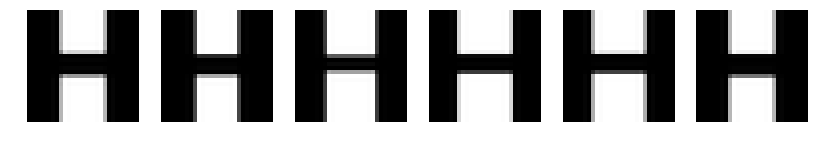

In [16]:
items = train_hash_df.loc[train_hash_df['img_hash_str'] == 'a08a20208a8a2020'][:6].index
plt.figure(figsize=(14, 5))
for i, item in enumerate(items):
    plt.subplot(1, 6, i+1)
    plt.axis('off')
    #plt.title(pretty_labels[labels[item]])
    plt.imshow(train_dataset_proc[item], cmap='Greys')

In [17]:
train_hash_df_dropped = train_hash_df.drop_duplicates(subset='img_hash_str', keep='first')
valid_hash_df_dropped = valid_hash_df.drop_duplicates(subset='img_hash_str', keep='first')
test_hash_df_dropped = test_hash_df.drop_duplicates(subset='img_hash_str', keep='first')

In [19]:
print("Train size before: {}\nTrain size after: {}\n".format(train_hash_df.shape[0], train_hash_df_dropped.shape[0]))
print("Valid size before: {}\nValid size after: {}\n".format(valid_hash_df.shape[0], valid_hash_df_dropped.shape[0]))
print("Test size before: {}\nTest size after: {}".format(test_hash_df.shape[0], test_hash_df_dropped.shape[0]))

Train size before: 200000
Train size after: 172828

Valid size before: 10000
Valid size after: 9686

Test size before: 10000
Test size after: 9537


In [23]:
train_dataset = train_dataset[train_hash_df_dropped.index]
train_labels = train_labels[train_hash_df_dropped.index]

valid_dataset = valid_dataset[valid_hash_df_dropped.index]
valid_labels = valid_labels[valid_hash_df_dropped.index]

test_dataset = test_dataset[test_hash_df_dropped.index]
test_labels = test_labels[test_hash_df_dropped.index]

In [27]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [28]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 603040646


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [5]:
train_dataset = data['train_dataset']
train_labels = data['train_labels']

test_dataset = data['test_dataset']
test_labels = data['test_labels']

In [6]:
train_dataset = train_dataset.reshape(train_dataset.shape[0], -1)
test_dataset = test_dataset.reshape(test_dataset.shape[0], -1)

In [10]:
%%time
sizes = [50, 100, 1000, 5000, len(train_dataset)]
for size in sizes:
    clf = LogisticRegression()
    clf.fit(train_dataset[:size], train_labels[:size])
    print("Train sample size: {}\nAccuracy: {}\n".format(size, clf.score(test_dataset, test_labels)))

Train sample size: 50
Accuracy: 0.5967

Train sample size: 100
Accuracy: 0.7447

Train sample size: 1000
Accuracy: 0.8253

Train sample size: 5000
Accuracy: 0.8475

Train sample size: 200000
Accuracy: 0.8905

CPU times: user 40min 28s, sys: 7.26 s, total: 40min 35s
Wall time: 41min 56s


Almost the same result with SGDClassifier

In [7]:
from sklearn.linear_model import SGDClassifier

In [10]:
%%time
clf = SGDClassifier(loss='log', max_iter=10)
clf.fit(train_dataset, train_labels)
print("Accuracy: {}".format(clf.score(test_dataset, test_labels)))

Accuracy: 0.8859
CPU times: user 1min 12s, sys: 1.04 s, total: 1min 13s
Wall time: 1min 13s
